In [21]:
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 15, 'font.family': "Times New Roman"})
csfont = {'fontname':'Times New Roman'}

In [22]:
def draw_ellipse(position, covariance, ax=None, label=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 5):
        if nsig == 1:
            ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                 angle, label=label, **kwargs))
        else:
            ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                 angle, **kwargs))
            

def draw_example(X, y, ax, title):
    ms = 15

    w_factor = 0.4 / max(weights)
    colors = ['gray', 'c', 'orange']
    labels = ['Client 1', 'Client 2', 'Client 3']
    hatches = ['-', '--', '-.']
    for paras, w, c, l, h in zip(parameters, weights, colors, labels, hatches):
        draw_ellipse(np.array(paras[0]), np.array(paras[1]), 
                     ax=ax, label=l, alpha=w * w_factor, color=c, ls=h, ec='black')
        
    X0,X1 = X[y==0], X[y==1]
    scatter0 = ax.scatter(X0[:, 0], X0[:, 1], s=ms, color='r', facecolors='none')
    scatter1 = ax.scatter(X1[:, 0], X1[:, 1], s=ms, marker='x', color='b')
    scatter0.set_zorder(4)
    scatter1.set_zorder(4)
    
    a = np.arange(-2, 2.1, 0.1)
    b = 1 - a
    b1 = (- model.intercept_ - model.coef_[0,0] * a) / model.coef_[0,1]
    lw = 2
    true = ax.plot(a, b, '--', label='True plane',color='black', linewidth=lw, zorder=5)
    fedavg = ax.plot(a, b1, label='FedAvg', color='green', linewidth=lw, zorder=5)
        
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 3)
    ax.set_xlabel('$x_1$ \n\n' + title, **csfont)
    ax.grid(which='major', alpha=0.6, ls = '-.')
    

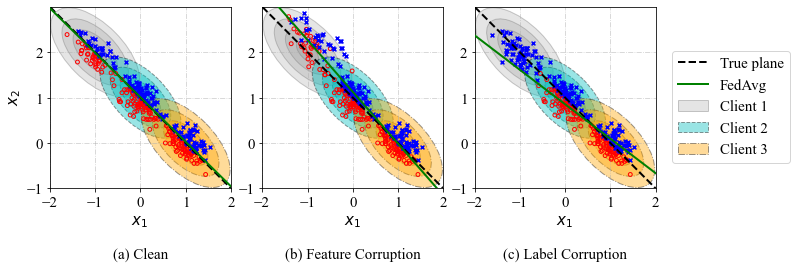

In [23]:
np.random.seed(0)


p = 0.6
parameters = [([-1, 2], [[0.06, -0.06 * p], [-0.06 * p, 0.06]]),
              ([0.0, 1.0], [[0.05, -0.05 * p], [-0.05 * p, 0.05]]), 
              ([1.0, 0.0], [[0.06, -0.06 * p], [-0.06 * p, 0.06]])
             ]
weights = [0.2, 0.4, 0.4]
client = []
for i in range(350):
    c = np.random.choice([0, 1, 2], p=weights)
    client.append(c)


num_samples = [client.count(i) for i in [0, 1, 2]]

X = np.concatenate([np.random.multivariate_normal(parameters[i][0], parameters[i][1], n) 
                    for i, n in zip([0, 1, 2], num_samples)],
                   axis=0)
y = np.array([1 if s[0]+s[1] >= 1 else 0 for s in X])


X0,X1 = X[y==0], X[y==1]
model = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
width = 11
fig, axs = plt.subplots(1, 3, figsize=(width, width / 3))
axs[0].set_ylabel('$x_2$', **csfont)
draw_example(X, y, axs[0], '(a) Clean')

X1, y1 = np.copy(X), np.copy(y)
noise_para = ([0.2, 0.2], [[0.06, -0.06 * p], [-0.06 * p, 0.06]])
for i in range(num_samples[0]):
    X1[i] += np.random.multivariate_normal(noise_para[0], noise_para[1])

model = LogisticRegression(random_state=0, fit_intercept=True).fit(X1, y1)
draw_example(X1, y1, axs[1], '(b) Feature Corruption')

X2, y2 = np.copy(X), np.copy(y)
y2[:num_samples[0]] = 1 
model = LogisticRegression(random_state=0, fit_intercept=True).fit(X2, y2)
draw_example(X2, y2, axs[2], '(c) Label Corruption')

plt.legend(bbox_to_anchor=(1.05, 0.8))
plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3)
plt.savefig('example', dpi=100)
plt.show()